# Pawssionate Data: Using animal shelter data to predict adoption outcome

## Summary

The aim of this project is to determine whether or not an animal gets adopted while predicting which of their characteristics influences potential owner's decision. Is it their name or gender? Their breed? The colour of their fur? There are a lot of factors at present. This project should hopefully shed some light on this.

Random Forest Models is applied in this project to predict the outcome of animal shelters using Austin Animal Center Data. 

### Research Questions

- Which features are most predictive of whether or not an animal gets adopted
- Which animal names are the most desirable for adoptions
- What days of the week result in the most adoptions

And to answer these questions, random forests and decision trees is applied.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly 
import plotly.express as px
import plotly.graph_objs as go

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Keeping track of runtime.
import timeit

# Decision trees
from sklearn import tree
from IPython.display import Image

# Packages for rendering tree.
import pydotplus
import graphviz
from graphviz import Source

# Random Forest
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import tree

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Support Vector Machine
from sklearn.svm import SVC

# Label Encoder
from sklearn.preprocessing import LabelEncoder

#Stylings
sns.set(style="white", color_codes=True)

#API
import requests

In [2]:
outcome_data = pd.read_csv('outcome.csv')

In [3]:
outcome_data.head()
outcome_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133728 entries, 0 to 133727
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         133728 non-null  object
 1   name              92026 non-null   object
 2   datetime          133728 non-null  object
 3   monthyear         133728 non-null  object
 4   date_of_birth     133728 non-null  object
 5   outcome_type      133728 non-null  object
 6   animal_type       133728 non-null  object
 7   sex_upon_outcome  133727 non-null  object
 8   age_upon_outcome  133683 non-null  object
 9   breed             133728 non-null  object
 10  color             133728 non-null  object
 11  outcome_subtype   64874 non-null   object
dtypes: object(12)
memory usage: 12.2+ MB


In [4]:
outcome_data.nunique()

animal_id           128417
name                 24730
datetime              3242
monthyear             3242
date_of_birth         7711
outcome_type            11
animal_type              5
sex_upon_outcome         5
age_upon_outcome        53
breed                 2778
color                  621
outcome_subtype         26
dtype: int64

# Exploratory Data Analysis

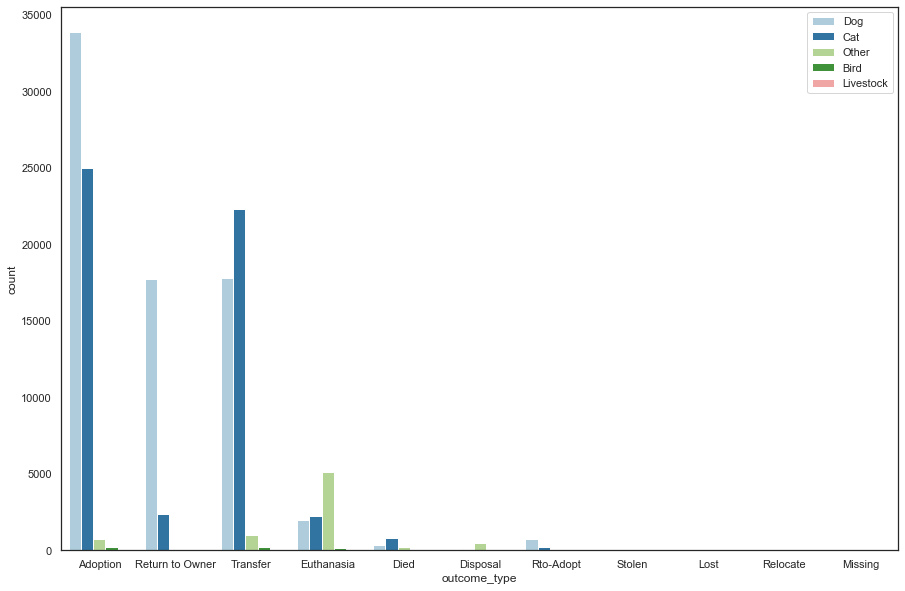

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(x='outcome_type', data=outcome_data, palette='Paired', hue = 'animal_type')
plt.legend(loc = 'upper right')

It would appear that the most common outcome is *adoption* followed by *transfer* and *returned to owner* while there are figures for euthanised this outcome type seems to be lower and other outcomes occur rarely. The adoption rate for **dogs** are predominantly higher than other species and they are most likely to be reunited with their owners. Meanwhile, **cats** also have higher adoption rates and are most likely to get transferred. The figures for euthanasia are considerably low and most likely to be the outcome for **other** species.

In [6]:
outcome_data.groupby(['outcome_type','outcome_subtype']).size()

outcome_type     outcome_subtype    
Adoption         Barn                       3
                 Foster                 12556
                 Offsite                  418
Died             At Vet                    99
                 Emergency                  8
                 Enroute                   91
                 In Foster                315
                 In Kennel                685
                 In Surgery                28
Euthanasia       Aggressive               576
                 At Vet                   207
                 Behavior                 160
                 Court/Investigation       48
                 Medical                  330
                 Rabies Risk             4159
                 Suffering               3611
                 Underage                  37
Missing          In Foster                 25
                 In Kennel                 16
                 Possible Theft            15
Return to Owner  Customer S                

<AxesSubplot:xlabel='animal_type', ylabel='count'>

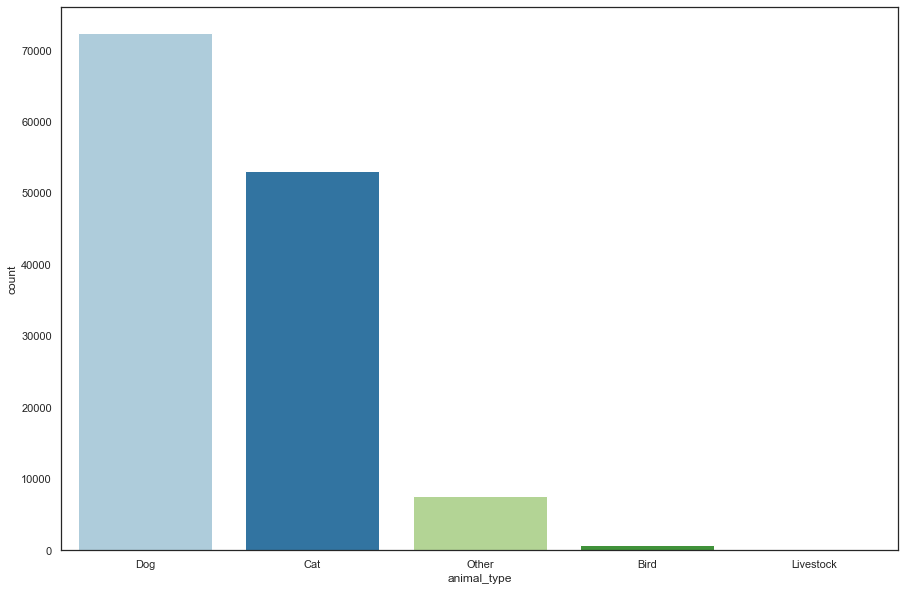

In [7]:
plt.figure(figsize=(15,10))
sns.countplot(x='animal_type', 
              data=outcome_data, 
              palette='Paired')

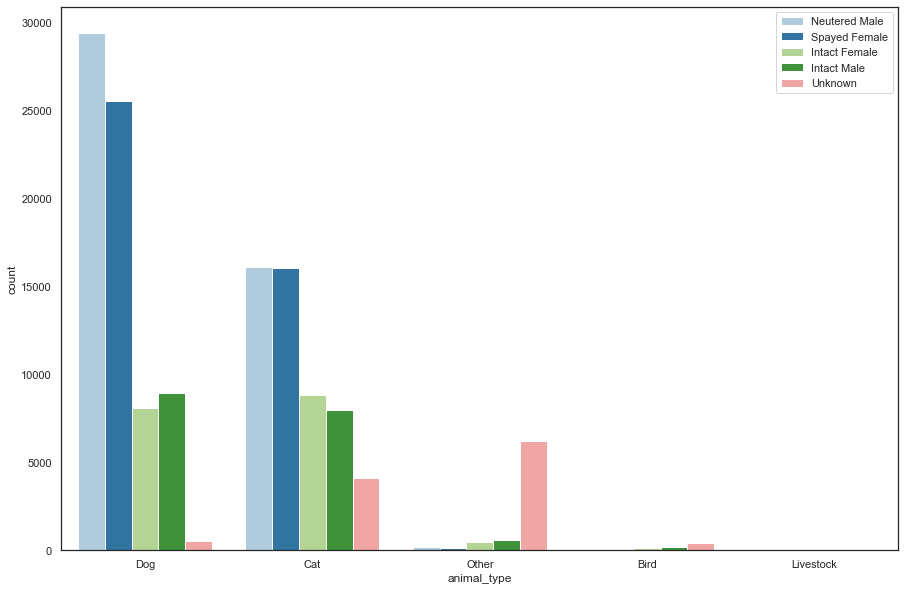

In [8]:
plt.figure(figsize=(15,10))
sns.countplot(x='animal_type', 
              data=outcome_data, 
              palette='Paired', 
              hue = 'sex_upon_outcome')
plt.legend(loc = 'upper right')

The charts above reveals that **dogs** are the most common animal type in Austin shelter, followe by **cats**. Although, there are also other animal types (assuming this could be wildlife or exotic animals). There is almost an equal distribution in number of neutered males and spayed females for both dogs and cats. 

<AxesSubplot:xlabel='sex_upon_outcome', ylabel='count'>

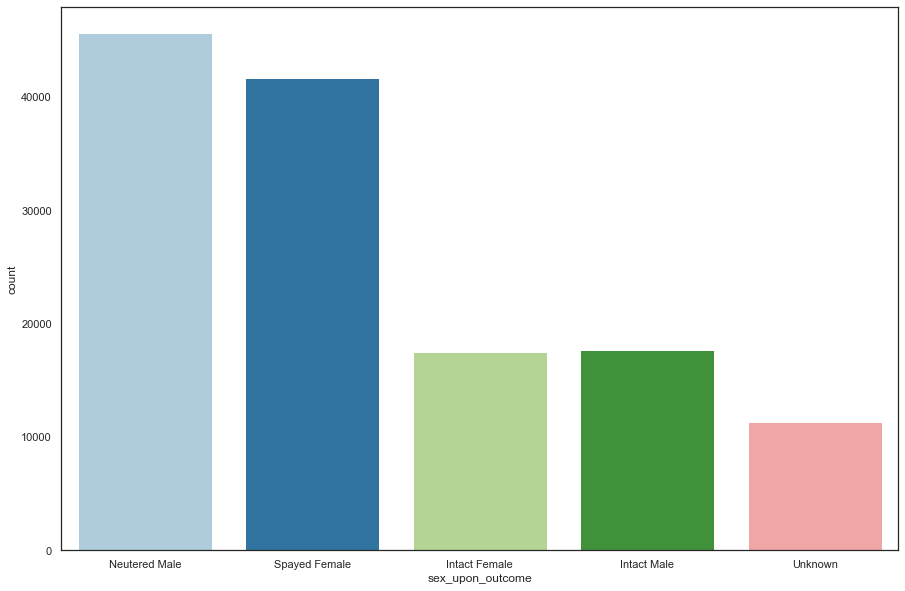

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(x = 'sex_upon_outcome', 
              data = outcome_data, 
              palette = 'Paired')

Though if we look closely at the number of sex upon outcome alone, majority are **neutered males** and **spayed female**, while a the rest are **intact and unknown**.

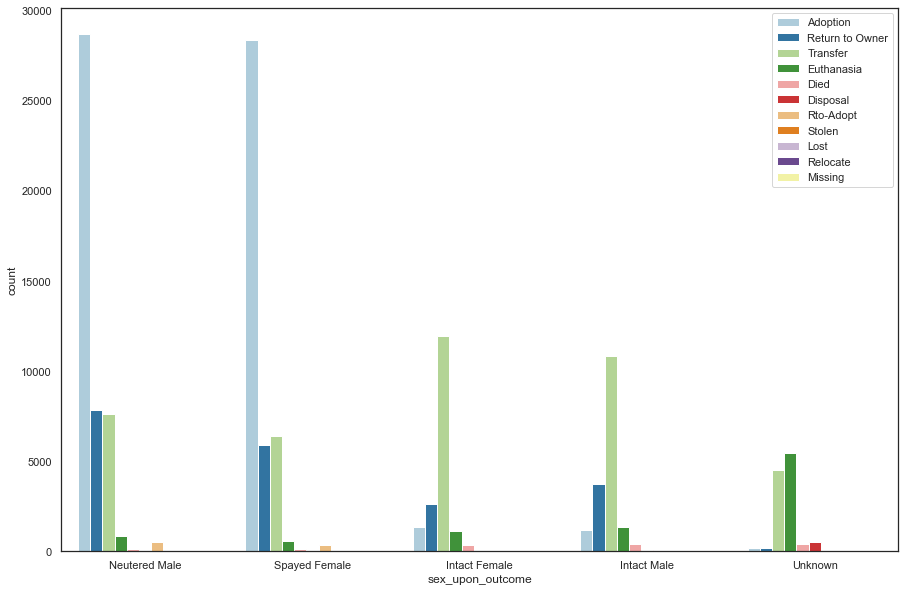

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(data=outcome_data,
              x='sex_upon_outcome',
              hue='outcome_type',
              palette='Paired')
plt.legend(loc='upper right')
plt.show()

The chart above shows the outcome type grouped by sex upon outcome. It is apparent that neutered males and spayed females are most likely to get adopted compared to intact male or female. This may not be the case entirely, it could be the case of these animals are neutered or spayed before adoption hence why the rates are higher. Regardless of this, the sex of the animal is most likely to affect their adoption prospect. 

# Feature Engineering

This section will allow leveraging data to create new variables that does not exist from the data set. The aim is to create features that the models can use. The columns frequently include many bits of other data. For instance, the age column contains animals that are aged either in years or months and sex upon outcome includes neutered, spayed or intact. 

The engineered features are including:

1. **Name:** Name vs no name vs animal ID as name
2. **Sex and Intact:** Male vs Female vs unknown, Intact vs fixed vs unknown
3. **Age:** Months, days, years
4. **Time of outcome:** The month, year, weekday and season the outcome occurred
5. **Age category:** Kitten/Puppy, Senior
6. **Breed:** Breed of animal, mixed or pedigree
7. **Coat and fur pattern:** Information of their coat/fur, colour and pattern

# Adoption Outcome using Binary Classification

This section focuses on developing an outcome feature that only records whether an animal is adopted or not (1 = adopted, 0 = not adopted).

In [11]:
# Create a feature that determines whether an animal is adopted or not

outcome_data['adopt_bi'] = np.where(outcome_data['outcome_type'] == 'Adoption', 1, 0)

In [12]:
# Create a feature that establishes whether an animal with name or no name are most likely to get adopted

outcome_data['name_bi'] = np.where(outcome_data['name'].isnull(), 0, 1)

<AxesSubplot:>

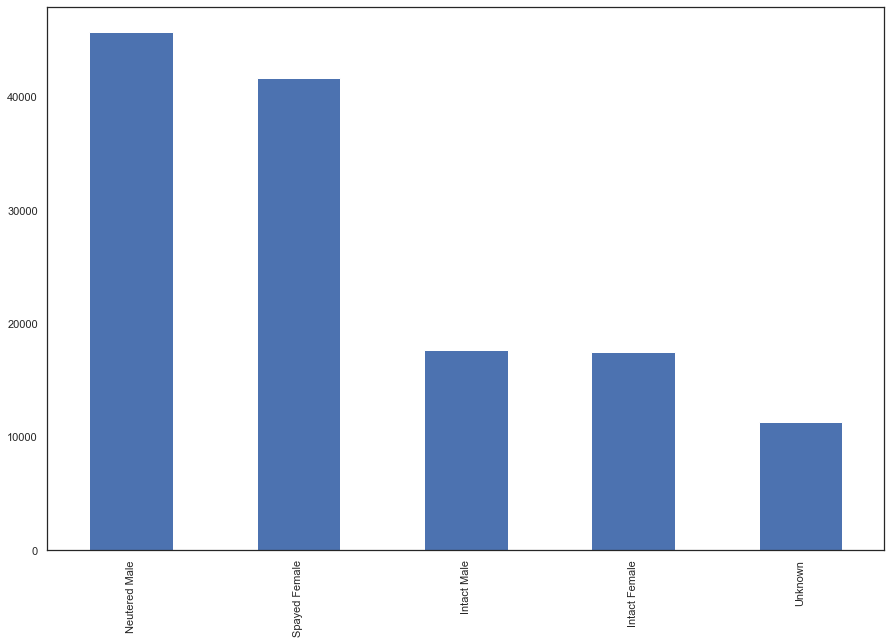

In [13]:
# Count the number of animal based on their sex upon outcome
plt.figure(figsize=(15,10))
outcome_data.sex_upon_outcome.value_counts().plot(kind = 'bar')

Majority of the animals adopted are neutered male and spayed female. This could be because it reduces the risk of unwanted litters as well as any behavioural issues caused by being intact. Though it is also possible that their intake are mostly neutered and spayed which caused the huge discrepancy in numbers. 

In [14]:
# Show null values in sex upon outcome column
outcome_data.sex_upon_outcome.isnull().sum()

1

In [15]:
# Assign the null field from sex upon outcome as unknown

outcome_data['sex_upon_outcome'].fillna('Unknown', inplace=True)

In [16]:
# Create a separate column for males 

outcome_data['male'] = outcome_data['sex_upon_outcome'].apply(lambda x: 1 if 'Male' in x else 2 if 'Unknown' in x else 0)

In [17]:
# Create a separate column for females 

# outcome_data['female'] = outcome_data['sex_upon_outcome'].apply(lambda x: 1 if 'Female' in x else 2 if 'Unknown' in x else 0)

In [18]:
# Create a column specifically for intact 

outcome_data['intact'] = outcome_data['sex_upon_outcome'].apply(lambda x: 1 if 'Intact' in x else 2 if 'Unknown' in x else 0)

In [19]:
##print(outcome_data)


### Age converted into days, years
Age upon outcome is currently listed as a string. Converting this to days would be useful. To accomplish this, the strings are separated by the number and the time period, and the number in days is obtained by multiplying it by the appropriate factor.

In [20]:
outcome_data.age_upon_outcome.isnull().sum()

45

The age upon outcome column contains 45 null values. Because there are only a small amount of missing data points, the most common value will be used to fill in the blanks.

In [21]:
outcome_data['age_upon_outcome'].fillna(outcome_data['age_upon_outcome'].value_counts().index[0], inplace=True)

In [22]:
outcome_data['number'] = outcome_data['age_upon_outcome'].str.split(' ').str[0].astype(int)
outcome_data['time_period'] = outcome_data['age_upon_outcome'].str.split(' ').str[1]

In [23]:
outcome_data['time_period'] = np.where(outcome_data['time_period'].str.contains('day'), 1, 
                                   np.where(outcome_data['time_period'].str.contains('week'), 7, 
                                            np.where(outcome_data['time_period'].str.contains('month'), 30, 
                                                     np.where(outcome_data['time_period'].str.contains('year'), 365, 0)))).astype(int)

In [24]:
outcome_data['outcome_age_days'] = outcome_data['number'] * outcome_data['time_period']
outcome_data['outcome_age_years'] = (outcome_data['outcome_age_days'] / 365).round(5)

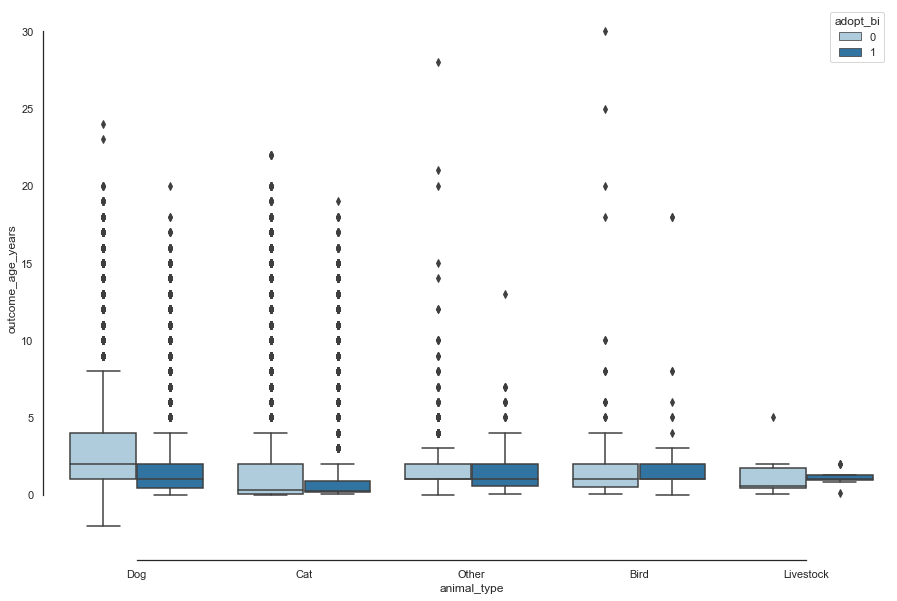

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(x="animal_type", y="outcome_age_years",hue="adopt_bi", data=outcome_data, palette="Paired")
sns.despine(offset=10, trim=True)

The box plot indicates that younger animals are more likely to be adopted than other/older age groups. Dogs have a higher median for other outcomes (0) than other species, which have a lower adoption outcome. This suggests that the age of the animal has a significant impact on its chances of adoption.

In [26]:
# Converting 'datetime' column into readable date and times.
outcome_data['datetime'] = pd.to_datetime(outcome_data['datetime'])

# Extract month and year from the data
outcome_data['outcome_month'] = outcome_data['datetime'].dt.month
outcome_data['outcome_year'] = outcome_data['datetime'].dt.year
outcome_data['outcome_weekday'] = outcome_data['datetime'].dt.day_name()
outcome_data['outcome_hour'] = outcome_data['datetime'].dt.hour

# Add column to specify season 
outcome_data['outcome_season'] = np.where(outcome_data['outcome_month'].between(3,5, inclusive=True), 'Spring',
                                      np.where(outcome_data['outcome_month'].between(6,8, inclusive=True), 'Summer',
                                               np.where(outcome_data['outcome_month'].between(9,11, inclusive=True), 'Autumn',
                                                        np.where(outcome_data['outcome_month'].between(3,4, inclusive=True), 'Spring','Winter'))))

<AxesSubplot:>

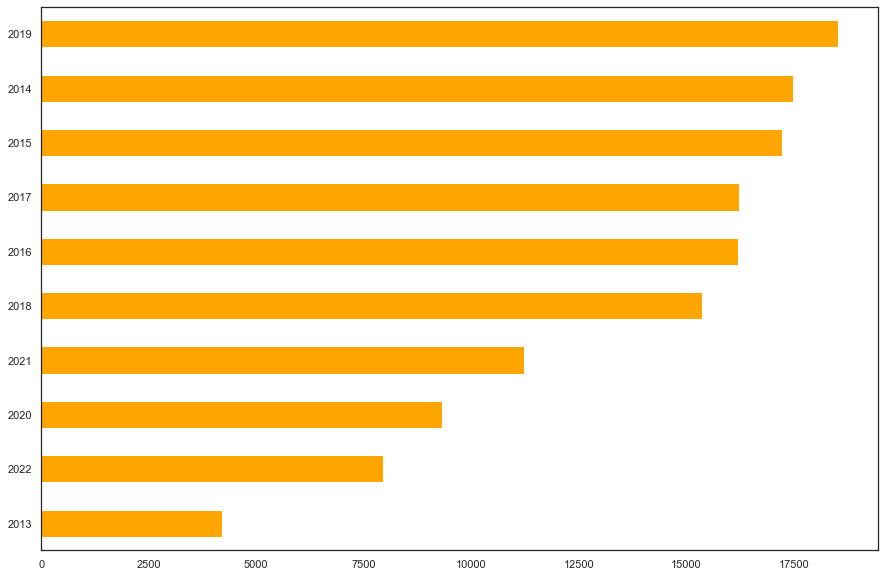

In [27]:
plt.figure(figsize=(15,10))
outcome_data['outcome_year'].value_counts().sort_values().plot(kind = 'barh', color = 'orange')

The chart is arranged is ordered in ascending order and it would appear that 2019 was the busiest year for the shelter. 

<AxesSubplot:>

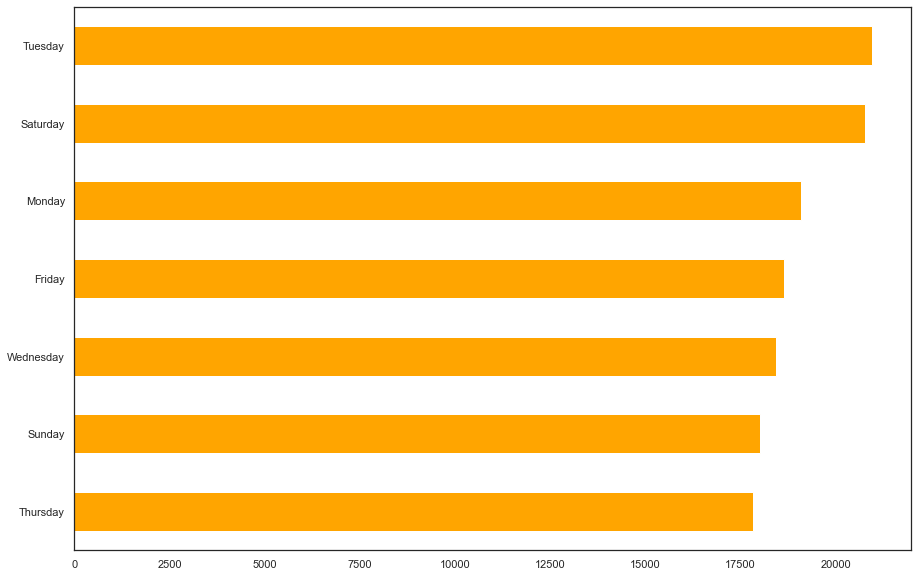

In [28]:
plt.figure(figsize=(15,10))
outcome_data['outcome_weekday'].value_counts().sort_values().plot(kind = 'barh', color = 'orange')

Tuesdays and Saturdays have the highest rate of adoption, as seen from the bar plot. Because there appears to be a balanced distribution of figures, it is difficult to determine whether adotpions are more likely to occur on weekends or weekdays. However, it is clear that animals are more likely to be adopted on Tuesdays and less likely to be adopted on Thursdays.

### Age category

Kittens and puppies are more likely to be adopted than adult cats and dogs, while senior dogs and cats are less likely to be adopted. It will be useful to include a feature that differentiates the animals based on their life stage.

In [29]:
cats = outcome_data[outcome_data['animal_type'] == 'Cat']
dogs = outcome_data[outcome_data['animal_type'] == 'Dog']

In [30]:
# Cats are considered as kittens < 180 (6 months)
# Dogs are considered as puppies < 270 (9 months)
cats['kitten'] = np.where(cats['outcome_age_days'] < 180, 1, 0)
dogs['puppy'] = np.where(dogs['outcome_age_days'] < 270, 1, 0)

# Seniors are 
cats['senior'] = np.where(cats['outcome_age_years'] >= 11, 1, 0)
dogs['senior_large'] = np.where(dogs['outcome_age_years'] == 5, 1, 0)
dogs['senior_med_small'] = np.where(dogs['outcome_age_years'] >= 7, 1, 0)

### Dog Breeds

In [31]:
dogs.breed.value_counts()

Pit Bull Mix                                 7876
Labrador Retriever Mix                       6902
Chihuahua Shorthair Mix                      6225
German Shepherd Mix                          3103
Pit Bull                                     1931
                                             ... 
Labrador Retriever/Parson Russell Terrier       1
Mastiff/Staffordshire                           1
Dachshund Longhair/Rat Terrier                  1
West Highland/Soft Coated Wheaten Terrier       1
Pit Bull/Border Terrier                         1
Name: breed, Length: 2457, dtype: int64

In [32]:
dogs['breed'] = dogs['breed'].str.lower()

In [33]:
dogs['mix'] = np.where(dogs['breed'].str.contains("mix"), 1, 0)

In [34]:
# Dropping "mix" and stripping whitespace.

dogs['del_mixed'] = dogs['breed'].str.replace('mix', '').str.strip()  

# Splitting records with two breeds into two columns for each breed.
dogs = pd.concat([dogs, dogs['del_mixed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], axis=1)

In [35]:
dogs.drop(2, axis=1, inplace=True)

### Cat Breeds

In [36]:
cats.breed.value_counts()

Domestic Shorthair Mix           31926
Domestic Shorthair               11722
Domestic Medium Hair Mix          3195
Domestic Longhair Mix             1579
Siamese Mix                       1327
                                 ...  
Cornish Rex                          1
Oriental Sh                          1
Domestic Shorthair/Maine Coon        1
Birman Mix                           1
Angora/Persian                       1
Name: breed, Length: 105, dtype: int64

In [37]:
cats['breed'] = cats['breed'].str.lower()

In [38]:
cats['mix'] = np.where(cats['breed'].str.contains("mix"), 1, 0)

In [39]:
cats['del_mixed'] = cats['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()     

In [40]:
off_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese Javanese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic Shorthair', 'Havana Brown', 'Himalayan', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 'Manx', 
              'Munchkin','Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

off_breeds = [i.lower() for i in off_breeds]
off_breeds = '|'.join(off_breeds)

off_breeds

'abyssinian|american bobtail|american curl|american shorthair|american wirehair|balinese javanese|bengal|birman|bombay|british shorthair|burmese|burmilla|chartreux|colorpoint shorthair|cornish rex|devon rex|egyptian mau|european burmese|exotic shorthair|havana brown|himalayan|japanese bobtail|korat|laperm|maine coon|manx|manx|munchkin|norwegian forest cat|ocicat|oriental|persian|ragamuffin|ragdoll|russian blue|scottish fold|selkirk rex|siamese|siberian|singapura|somali|tonkinese|turkish angora|turkish van'

In [41]:
# Splitting records with two breeds into two columns for each breed.
# Splitting records with two breeds into two columns for each breed.
cats = pd.concat([cats, 
                     cats['del_mixed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

# If in the official breed list then mark as 1.
cats['off_breed'] = np.where((cats['breed1'].str.contains(off_breeds)) | 
                                (cats['breed2'].str.contains(off_breeds)), 
                                1, 0)

# If neither breed1 or breed2 columns contain official recognized breed, mark as domestic.
cats['domestic_breed'] = np.where((cats['breed1'].str.contains(off_breeds) == False) | 
                                     (cats['breed2'].str.contains(off_breeds) == False), 
                                     1, 0)

### Coat and fur patterns

Similar to breed, colour patterns are also categorised into two. Similar to the previous steps, these will be separated

### Cats

In [42]:
cats.color.value_counts()

Brown Tabby               8073
Black                     6948
Black/White               4839
Brown Tabby/White         4098
Orange Tabby              3936
                          ... 
Black/Tricolor               1
Tortie Point/Cream           1
Gray Tabby/Brown Tabby       1
Gray/Blue                    1
Lynx Point/Brown Tabby       1
Name: color, Length: 295, dtype: int64

In [43]:
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

In [44]:
coat_reg = '(' + '|'.join(coat_patterns) + ')'

coat_reg

'(tabby|tortie|tortoiseshell|calico|smoke|torbie|colorpoint|point|brindle|agouti|bicolor|tricolor)'

In [45]:
cats['colour'] = cats['color'].str.lower()

cats['coat_pattern'] = cats['color'].str.extract(coat_reg, expand=False)

cats['colour_edit'] = cats['color'].str.replace(coat_reg, '').str.strip()

In [46]:
cats = pd.concat([cats, 
                     cats['colour_edit'].str.split('/', expand=True).rename(columns={0:'colour1', 1:'colour2'})], axis=1)

#Replacing blanks in color1 with 'breed specific'.
cats['color1'] = np.where(cats['colour1'] == '', 'breed specific', cats['colour1'])

# Creating a column that collects the extracted coat colors and patterns.  If the color is breed specific, list 
# the coat pattern.  Otherwise, list the color.
cats['coat'] = np.where(cats['colour1'] == 'breed specific', cats['coat_pattern'], cats['colour1'])

### Dogs 

In [47]:
dogs.color.value_counts()

Black/White               8446
Brown/White               4129
White                     3929
Black                     3876
Tan/White                 3787
                          ... 
Tricolor/Cream               1
Calico                       1
Brown Brindle/Tricolor       1
Tan/Blue Merle               1
Liver/Brown Brindle          1
Name: color, Length: 387, dtype: int64

In [48]:
# Coat patterns for dogs
coat_patterns = ['bicolour','tricolour','merle','tuxedo','harlequin','spotted','tick','brindle','saddle',
                'sable']

# Create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

coat_reg

'(bicolour|tricolour|merle|tuxedo|harlequin|spotted|tick|brindle|saddle|sable)'

In [49]:
dogs['colour'] = dogs['color'].str.lower()

dogs['coat_pattern'] = dogs['color'].str.extract(coat_reg, expand=False)

dogs['colour_edit'] = dogs['color'].str.replace(coat_reg, '').str.strip()

In [50]:
#Splitting color column into two color columns
dogs = pd.concat([dogs, 
                     dogs['colour_edit'].str.split('/', expand=True).rename(columns={0:'colour1', 1:'colour2'})], axis=1)

#Replacing blanks in color1 with 'breed specific'.
dogs['colour1'] = np.where(dogs['colour1'] == '', 'breed specific', dogs['colour1'])

# Creating a column that collects the extracted coat colors and patterns.  If the color is breed specific, list 
# the coat pattern.  Otherwise, list the color.
dogs['coat'] = np.where(dogs['colour1'] == 'breed specific', dogs['coat_pattern'], dogs['colour1'])

# Modelling

The next step is creating the models to predict the outcomes for cats and dogs using the features created previously. 

In [51]:
cats2 = cats.drop(cats.iloc[:, 0:9], axis=1)
cats2 = cats.drop(['animal_id',
                   'breed',
                   'age_upon_outcome',
                   'name',
                   'datetime',
                   'monthyear',
                   'date_of_birth',
                   'color',
                   'animal_type',
                   'color',
                   'sex_upon_outcome',
                   'number',
                   'time_period',
                   'del_mixed',
                   'colour_edit',
                   'outcome_age_years',
                   'outcome_subtype',
                   'outcome_hour',
                   'breed2',
                   'coat_pattern',
                   'colour1',
                   'colour',
                   'color1',
                   'colour2'], axis=1)

In [52]:
print(cats2)

       outcome_type  adopt_bi  name_bi  male  intact  outcome_age_days  \
1          Adoption         1        0     0       0                90   
3          Adoption         1        1     0       0               365   
4          Adoption         1        0     0       0               120   
5          Adoption         1        1     0       1                60   
6          Adoption         1        1     0       0              1095   
...             ...       ...      ...   ...     ...               ...   
133717     Adoption         1        1     1       0               150   
133718     Adoption         1        1     0       0               180   
133724     Transfer         0        0     2       2                 7   
133725     Transfer         0        0     2       2                 7   
133726     Transfer         0        0     2       2                 7   

        outcome_month  outcome_year outcome_weekday outcome_season  kitten  \
1                   8          20

In [53]:
dogs2 = dogs.drop(dogs.iloc[:, 0:9], axis=1)
dogs2 = dogs.drop(['animal_id',
                   'breed',
                   'age_upon_outcome',
                   'name',
                   'datetime',
                   'monthyear',
                   'date_of_birth',
                   'color',
                   'animal_type',
                   'color',
                   'sex_upon_outcome',
                   'number',
                   'time_period',
                   'del_mixed',
                   'colour_edit',
                   'outcome_age_years',
                   'outcome_subtype',
                   'outcome_hour',
                   'breed2',
                   'coat_pattern',
                   'colour1',
                   'colour',
                   'colour2'], axis=1)

In [54]:
dogs2

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,puppy,senior_large,senior_med_small,mix,breed1,coat
0,Adoption,1,1,1,0,3285,8,2022,Saturday,Summer,0,0,1,0,jack russell terrier,White
2,Adoption,1,1,0,0,210,8,2022,Saturday,Summer,1,0,0,1,labrador retriever,Black
9,Adoption,1,1,0,0,60,8,2022,Saturday,Summer,1,0,0,0,labrador retriever,Black
10,Adoption,1,1,0,0,730,8,2022,Saturday,Summer,0,0,0,1,pit bull,Blue
11,Adoption,1,1,1,0,365,8,2022,Saturday,Summer,0,0,0,0,redbone hound,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133720,Adoption,1,1,0,0,1095,10,2013,Tuesday,Autumn,0,0,0,1,anatol shepherd,White
133721,Transfer,0,0,0,0,730,10,2013,Tuesday,Autumn,0,0,0,1,boxer,Red
133722,Transfer,0,0,1,0,1095,10,2013,Tuesday,Autumn,0,0,0,1,toy poodle,White
133723,Return to Owner,0,1,1,0,1460,10,2013,Tuesday,Autumn,0,0,0,1,bulldog,White


In [55]:
dogs2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72444 entries, 0 to 133727
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   outcome_type      72444 non-null  object
 1   adopt_bi          72444 non-null  int64 
 2   name_bi           72444 non-null  int64 
 3   male              72444 non-null  int64 
 4   intact            72444 non-null  int64 
 5   outcome_age_days  72444 non-null  int64 
 6   outcome_month     72444 non-null  int64 
 7   outcome_year      72444 non-null  int64 
 8   outcome_weekday   72444 non-null  object
 9   outcome_season    72444 non-null  object
 10  puppy             72444 non-null  int64 
 11  senior_large      72444 non-null  int64 
 12  senior_med_small  72444 non-null  int64 
 13  mix               72444 non-null  int64 
 14  breed1            72444 non-null  object
 15  coat              72444 non-null  object
dtypes: int64(11), object(5)
memory usage: 9.4+ MB


In [56]:
dogs2

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,puppy,senior_large,senior_med_small,mix,breed1,coat
0,Adoption,1,1,1,0,3285,8,2022,Saturday,Summer,0,0,1,0,jack russell terrier,White
2,Adoption,1,1,0,0,210,8,2022,Saturday,Summer,1,0,0,1,labrador retriever,Black
9,Adoption,1,1,0,0,60,8,2022,Saturday,Summer,1,0,0,0,labrador retriever,Black
10,Adoption,1,1,0,0,730,8,2022,Saturday,Summer,0,0,0,1,pit bull,Blue
11,Adoption,1,1,1,0,365,8,2022,Saturday,Summer,0,0,0,0,redbone hound,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133720,Adoption,1,1,0,0,1095,10,2013,Tuesday,Autumn,0,0,0,1,anatol shepherd,White
133721,Transfer,0,0,0,0,730,10,2013,Tuesday,Autumn,0,0,0,1,boxer,Red
133722,Transfer,0,0,1,0,1095,10,2013,Tuesday,Autumn,0,0,0,1,toy poodle,White
133723,Return to Owner,0,1,1,0,1460,10,2013,Tuesday,Autumn,0,0,0,1,bulldog,White


In [57]:
cats2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53003 entries, 1 to 133726
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   outcome_type      53003 non-null  object
 1   adopt_bi          53003 non-null  int64 
 2   name_bi           53003 non-null  int64 
 3   male              53003 non-null  int64 
 4   intact            53003 non-null  int64 
 5   outcome_age_days  53003 non-null  int64 
 6   outcome_month     53003 non-null  int64 
 7   outcome_year      53003 non-null  int64 
 8   outcome_weekday   53003 non-null  object
 9   outcome_season    53003 non-null  object
 10  kitten            53003 non-null  int64 
 11  senior            53003 non-null  int64 
 12  mix               53003 non-null  int64 
 13  breed1            53003 non-null  object
 14  off_breed         53003 non-null  int64 
 15  domestic_breed    53003 non-null  int64 
 16  coat              53003 non-null  object
dtypes: int64(12

In [58]:
cats2

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,kitten,senior,mix,breed1,off_breed,domestic_breed,coat
1,Adoption,1,0,0,0,90,8,2022,Saturday,Summer,1,0,0,domestic shorthair,0,1,Blue Cream
3,Adoption,1,1,0,0,365,8,2022,Saturday,Summer,0,0,0,domestic shorthair,0,1,Black
4,Adoption,1,0,0,0,120,8,2022,Saturday,Summer,1,0,0,domestic shorthair,0,1,Black
5,Adoption,1,1,0,1,60,8,2022,Saturday,Summer,1,0,1,domestic longhair,0,1,Cream Tabby
6,Adoption,1,1,0,0,1095,8,2022,Saturday,Summer,0,0,1,domestic shorthair,0,1,Blue Tabby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133717,Adoption,1,1,1,0,150,10,2013,Tuesday,Autumn,1,0,1,domestic shorthair,0,1,Black
133718,Adoption,1,1,0,0,180,10,2013,Tuesday,Autumn,0,0,1,domestic shorthair,0,1,Tortie
133724,Transfer,0,0,2,2,7,10,2013,Tuesday,Autumn,1,0,1,domestic shorthair,0,1,Orange
133725,Transfer,0,0,2,2,7,10,2013,Tuesday,Autumn,1,0,1,domestic shorthair,0,1,Orange


### Cat - Second DataFrame Heatmap 

<AxesSubplot:>

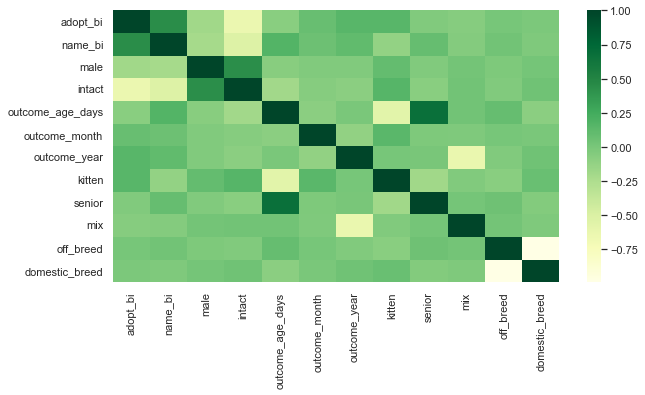

In [59]:
f, ax = plt.subplots(figsize=(10,5))
sns.set(font_scale=1)
sns.heatmap(cats2.corr(), cmap='YlGn')

### Dogs - Second DataFrame Heatmap 

<AxesSubplot:>

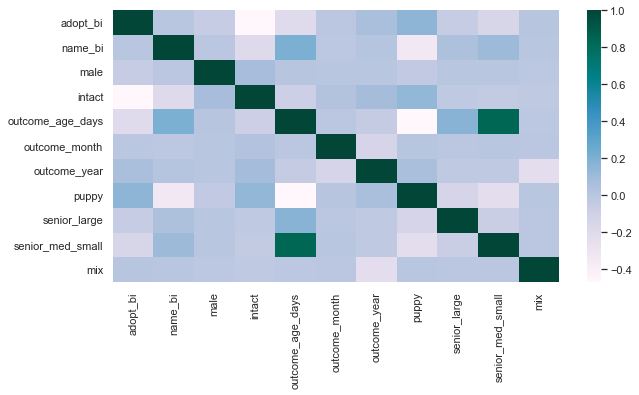

In [60]:
f, ax = plt.subplots(figsize=(10,5))
sns.set(font_scale=1)
sns.heatmap(dogs2.corr(), cmap='PuBuGn')

# Decision Tree

## Dogs adoption outcome

In [61]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 1,
    max_depth=4,
)

## Training and Testing Feature importance

In [62]:
dogs2_2 = dogs2

In [63]:
bi_columns = ['name_bi',
              'male',
              'intact',
              'puppy',
              'senior_med_small',
              'senior_large',
              'mix',
              'adopt_bi']
dogs2_2[bi_columns] = dogs2_2[bi_columns].astype(bool)

In [64]:
category_columns = ['outcome_month','outcome_year']
dogs2_2[category_columns] = dogs2_2[category_columns].astype(str)

In [65]:
columns = ['breed1','coat','outcome_season','outcome_weekday']

def encoder(df):
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(df[col])
        df[col] = label_encoder.transform(df[col])
    return df

In [66]:
encoder(dogs2_2).head(5)

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,puppy,senior_large,senior_med_small,mix,breed1,coat
0,Adoption,True,True,True,False,3285,8,2022,2,2,False,False,True,False,113,34
2,Adoption,True,True,False,False,210,8,2022,2,2,True,False,False,True,119,2
9,Adoption,True,True,False,False,60,8,2022,2,2,True,False,False,False,119,2
10,Adoption,True,True,False,False,730,8,2022,2,2,False,False,False,True,149,6
11,Adoption,True,True,True,False,365,8,2022,2,2,False,False,False,False,159,26


In [67]:
X1 = dogs2_2.drop(['outcome_type','adopt_bi'], 1)
Y1 = dogs2_2['adopt_bi']

decision_tree.fit(X1, Y1)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=1)

In [68]:
dtree = tree.DecisionTreeClassifier(criterion = "entropy")
dtree = dtree.fit(X1, Y1)

In [69]:
#from IPython.display import SVG
#fig, axe = plt.subplots(figsize=(20,10))
#graph = Source(tree.export_graphviz(dtree, 
#                                    out_file=None, 
#                                    feature_names=X1.columns,
#                                   filled = True,
#                                    rounded=True,  
#                                    special_characters=True,
#                                    class_names=['Not Adopted', 'Adopted']))
#SVG(graph.pipe(format='svg'))
#pydot_graph.set_size('"5,5!"')

In [70]:
##fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
##tree.plot_tree(dtree,
##               class_names=['Not Adopted', 'Adopted'],
##               feature_names=X1.columns,
 ##              filled = True);
##fig.savefig('imagename.png')

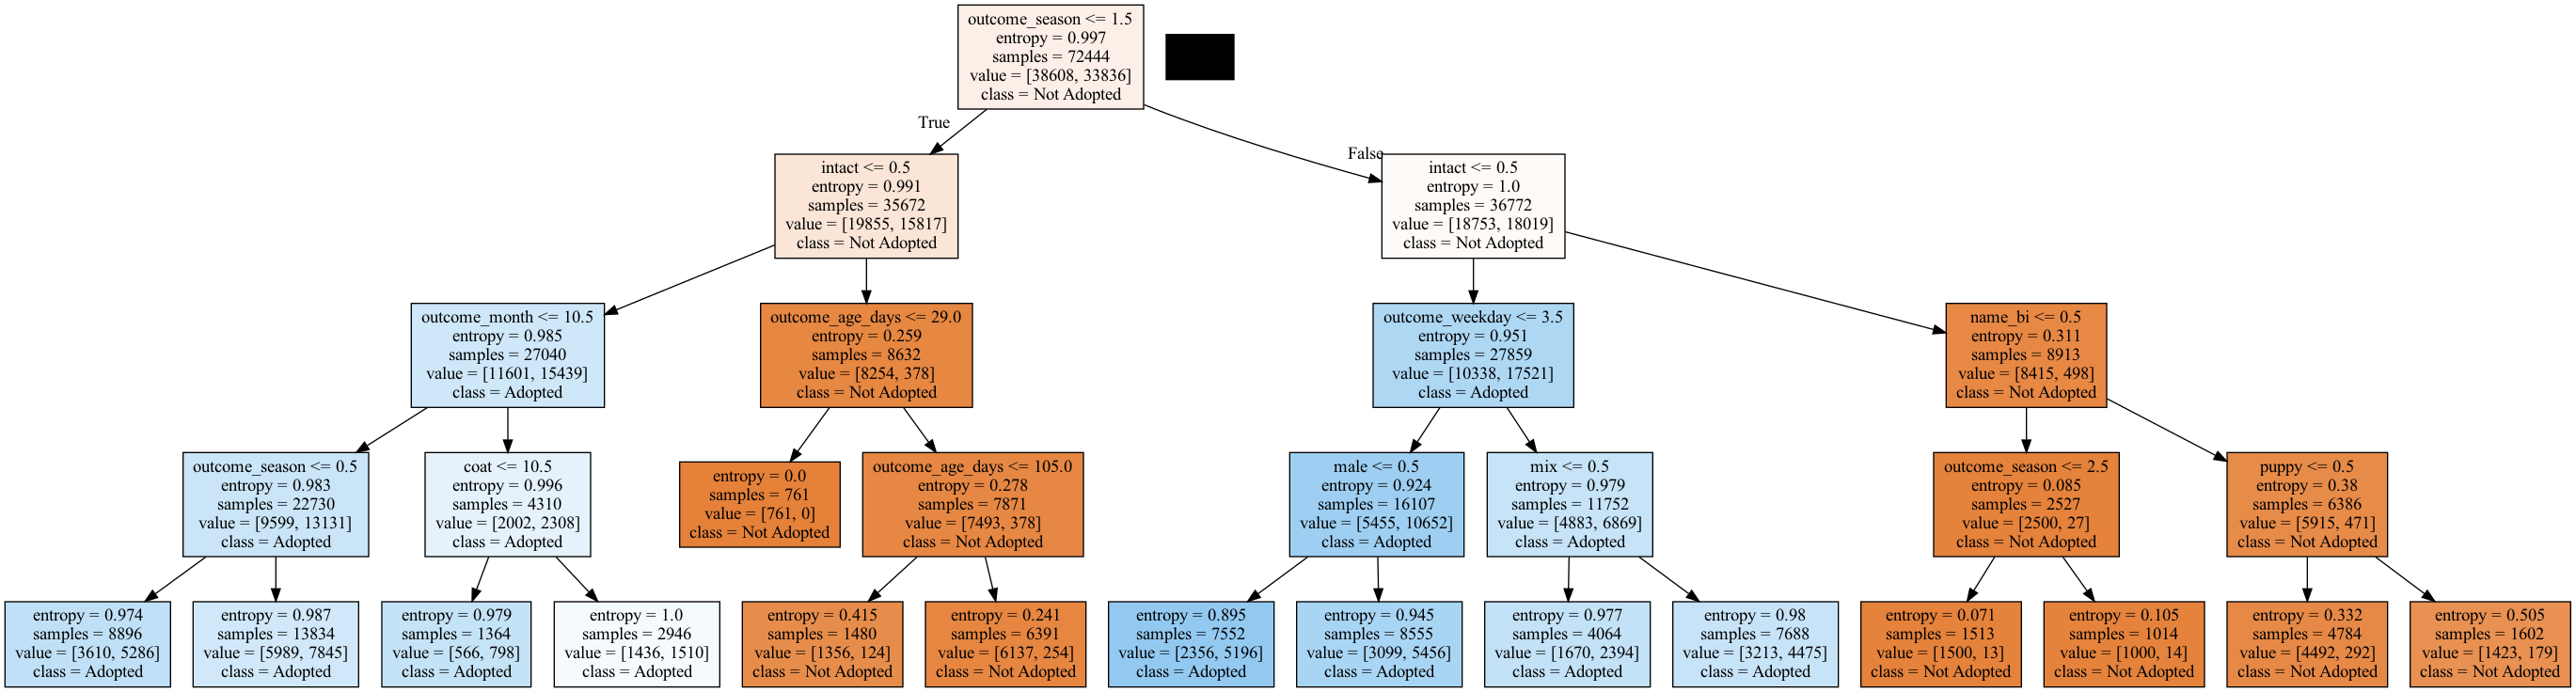

In [71]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X1.columns,
    class_names=['Not Adopted', 'Adopted'],
    filled=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [72]:
decision_tree.score(X1, Y1)

0.685067086301143

In [73]:
cross_val_score(decision_tree, X1, Y1, cv=5)

array([0.50127683, 0.74642832, 0.63565463, 0.5834081 , 0.56902264])

## Cats adoption outcome

In [74]:
cats2_2 = cats2

In [75]:
bi_columns = ['name_bi',
              'male',
              'intact',
              'kitten',
              'senior',
              'mix',
              'off_breed',
              'domestic_breed',
              'adopt_bi']
cats2_2[bi_columns] = cats2_2[bi_columns].astype(bool)

In [76]:
category_columns = ['outcome_month','outcome_year']
cats2_2[category_columns] = cats2_2[category_columns].astype(str)

In [77]:
encoder(cats2_2).head(5)

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,kitten,senior,mix,breed1,off_breed,domestic_breed,coat
1,Adoption,True,False,False,False,90,8,2022,2,2,True,False,False,18,False,True,8
3,Adoption,True,True,False,False,365,8,2022,2,2,False,False,False,18,False,True,2
4,Adoption,True,False,False,False,120,8,2022,2,2,True,False,False,18,False,True,2
5,Adoption,True,True,False,True,60,8,2022,2,2,True,False,True,16,False,True,23
6,Adoption,True,True,False,False,1095,8,2022,2,2,False,False,True,18,False,True,11


In [78]:
X2 = cats2_2.drop(['outcome_type','adopt_bi'], 1)
Y2 = cats2_2['adopt_bi']

decision_tree.fit(X2, Y2)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=1)

In [79]:
dtree2 = tree.DecisionTreeClassifier(criterion = "entropy")
dtree2 = dtree.fit(X2, Y2)

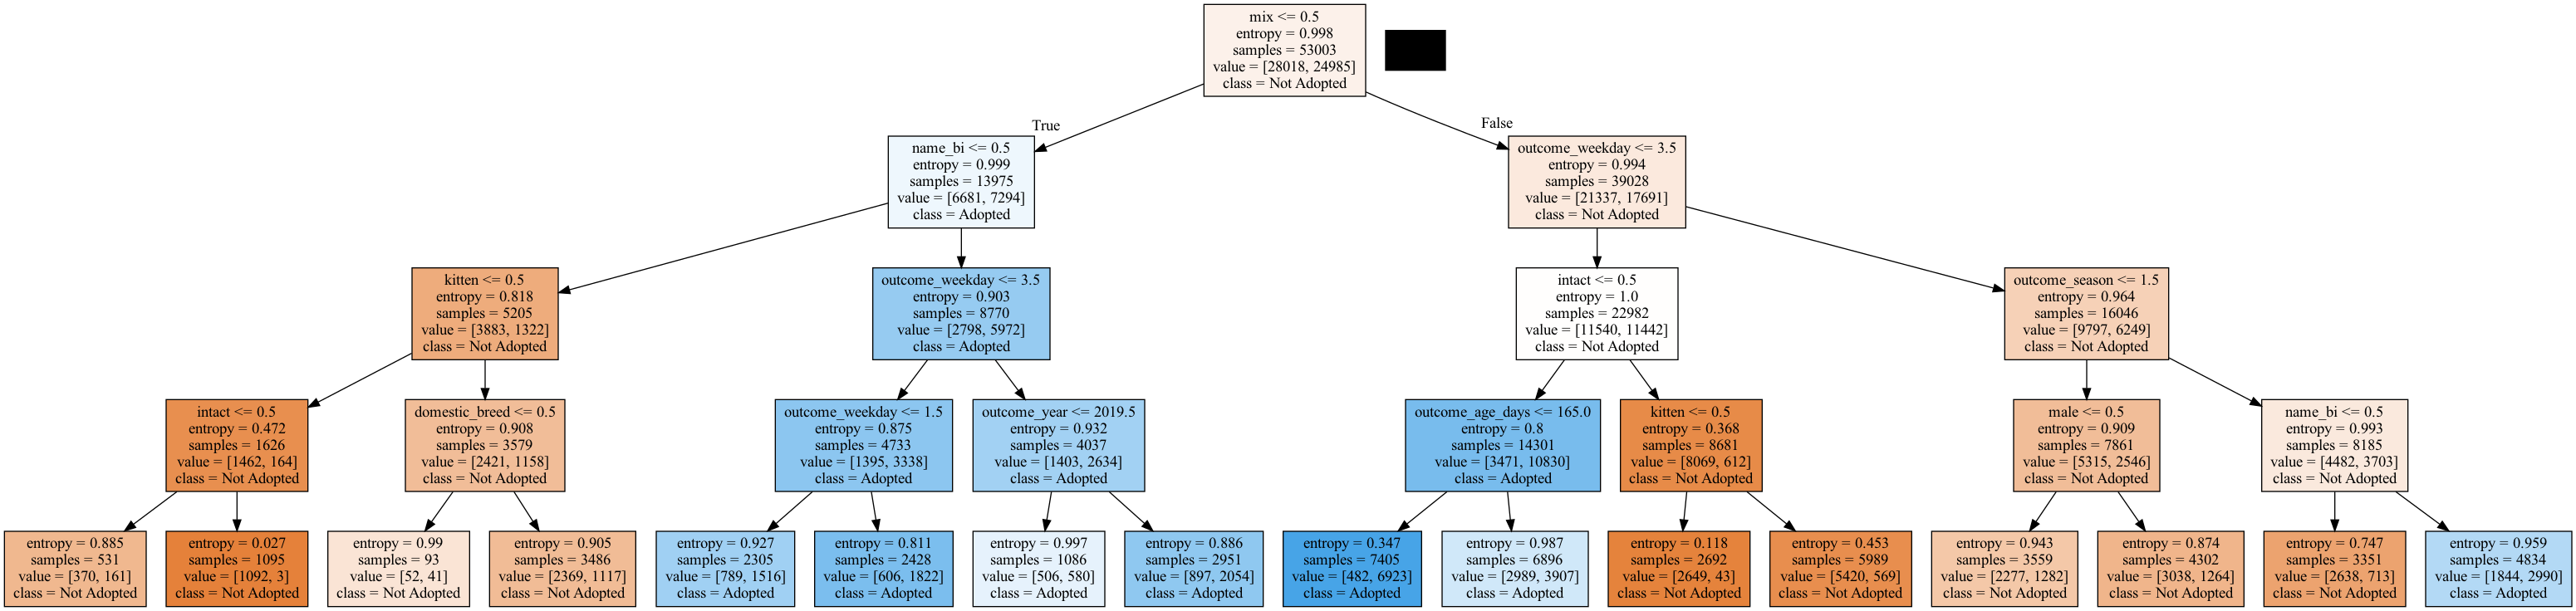

In [80]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X2.columns,
    class_names=['Not Adopted', 'Adopted'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [81]:
decision_tree.score(X2, Y2)

0.7489576061732355

In [82]:
cross_val_score(decision_tree, X2, Y2, cv=5)

array([0.53617583, 0.55504198, 0.69936798, 0.81556604, 0.51896226])

# Random Forest Classifier

## Cats - Outcome

In [83]:
rfc = ensemble.RandomForestClassifier()
X = cats2.drop(['outcome_type','adopt_bi'], 1)
y = cats2['outcome_type']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0, stratify=y)

In [84]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [85]:
rfc.score(X_test, y_test)

0.7991950191811835

In [86]:
cross_val_score(rfc, X, y, cv=5)

array([0.64456183, 0.3675125 , 0.21903594, 0.21320755, 0.4059434 ])

<AxesSubplot:xlabel='feature', ylabel='importance'>

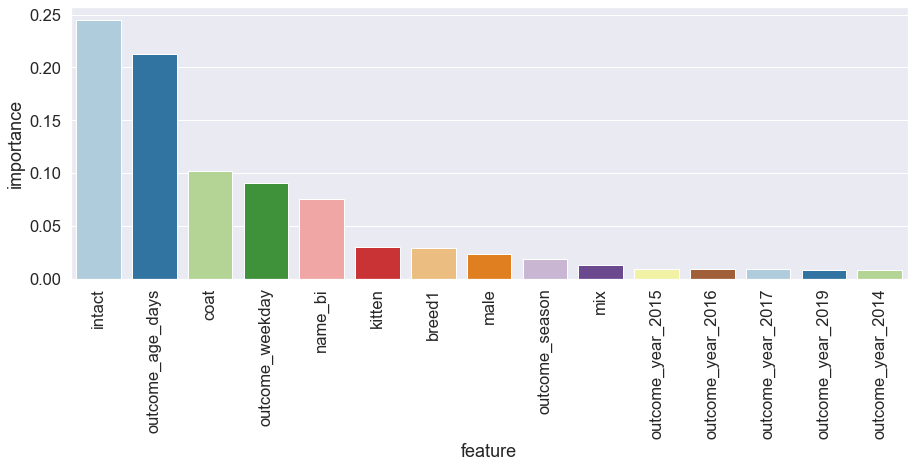

In [87]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': X.columns}, 
                           index=X.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15], palette = 'Paired')

## Dogs - Outcome

In [90]:
rfc2 = ensemble.RandomForestClassifier()
data_x = dogs2.drop(['outcome_type','adopt_bi'], 1)
data_y = dogs2['outcome_type']

data_x = pd.get_dummies(data_x)

x_train, x_test, y_train, y_test = train_test_split(data_x,data_y,test_size=0.33, random_state=42)

rfc2.fit(x_train, y_train)

RandomForestClassifier()

In [91]:
rfc2.score(x_test, y_test)

0.6188982306437445

In [92]:
cross_val_score(rfc2, data_x, data_y, cv=10)

array([0.52311939, 0.35182885, 0.31746032, 0.26887509, 0.24599669,
       0.20789619, 0.24682496, 0.28616786, 0.30342352, 0.34400883])

In [93]:
y_pred2 = rfc2.fit(x_train, y_train).predict(x_train)

<AxesSubplot:xlabel='feature', ylabel='importance'>

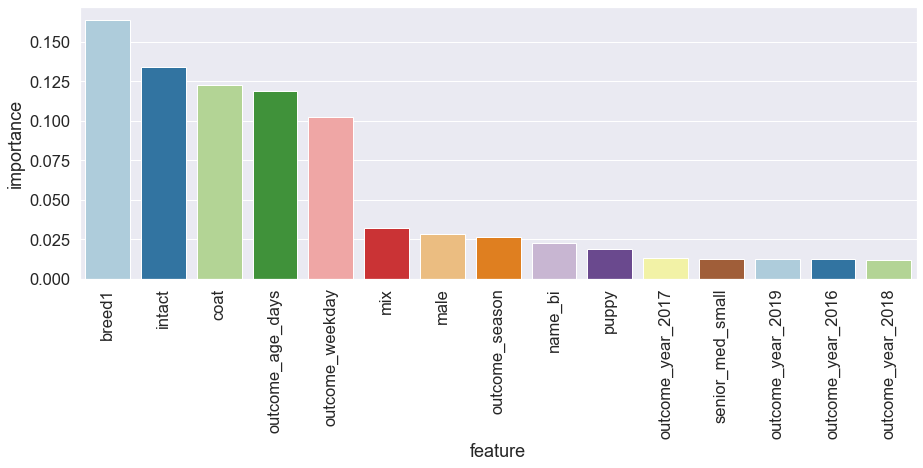

In [94]:
feature_importances2 = rfc2.feature_importances_

importances2 = pd.DataFrame({'importance': feature_importances2, 'feature': data_x.columns}, 
                           index=data_x.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances2[0:15], palette = 'Paired')

## Predicting Adoption for Cats

In [95]:
rfc = ensemble.RandomForestClassifier()
Xc = cats2.drop(['outcome_type','adopt_bi'], 1)
yc = cats2['adopt_bi']

# We need to get dummy variables for the categorical data
Xc = pd.get_dummies(Xc)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3,
                                                    random_state=0, stratify=yc)

rfc.fit(Xc_train, yc_train)

RandomForestClassifier()

In [96]:
rfc.score(Xc_test, yc_test)

0.8749135274511037

In [97]:
cross_val_score(rfc, Xc, yc, cv=5)

array([0.74775965, 0.55353269, 0.38251108, 0.52669811, 0.6990566 ])

In [98]:
yc_pred = rfc.fit(Xc_train, yc_train).predict(Xc_train)

In [99]:
conf_matrix = confusion_matrix(yc_train, yc_pred)
conf_matrix

array([[19438,   175],
       [   89, 17400]])

In [100]:
print('The sensitivity is: ' + str(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])))
print('The specificity is: ' + str(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])))

The sensitivity is: 0.9949110869689519
The specificity is: 0.991077346657829


<AxesSubplot:xlabel='feature', ylabel='importance'>

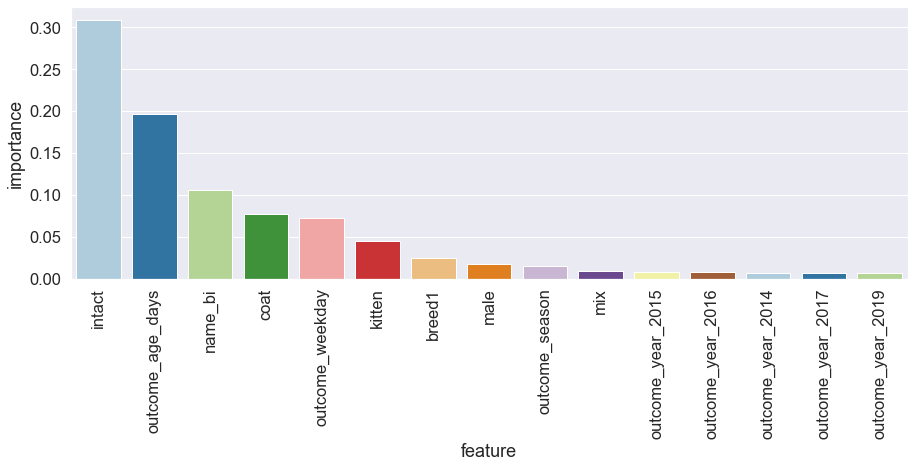

In [101]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': Xc.columns}, 
                           index=Xc.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15], palette = 'Paired')

## Predicting Adoption for Dogs

In [102]:
rfc3 = ensemble.RandomForestClassifier()
Xd = dogs2.drop(['outcome_type','adopt_bi'], 1)
yd = dogs2['adopt_bi']

# We need to get dummy variables for the categorical data
Xd = pd.get_dummies(Xd)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3,
                                                    random_state=0, stratify=yd)

rfc3.fit(Xd_train, yd_train)

RandomForestClassifier()

In [105]:
rfc3.score(Xd_test, yd_test)

0.7443176589675163

In [106]:
cross_val_score(rfc3, Xd, yd, cv=5)

array([0.64538616, 0.48975085, 0.41824833, 0.45896887, 0.63804528])

In [107]:
yd_pred = rfc3.fit(Xd_train, yd_train).predict(Xd_train)

In [108]:
conf_matrix = confusion_matrix(yd_train, yd_pred)
conf_matrix

array([[26917,   108],
       [   75, 23610]])

In [109]:
print('The sensitivity is: ' + str(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])))

print('The specificity is: ' + str(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])))

The sensitivity is: 0.9968334388853705
The specificity is: 0.9960037002775208


<AxesSubplot:xlabel='feature', ylabel='importance'>

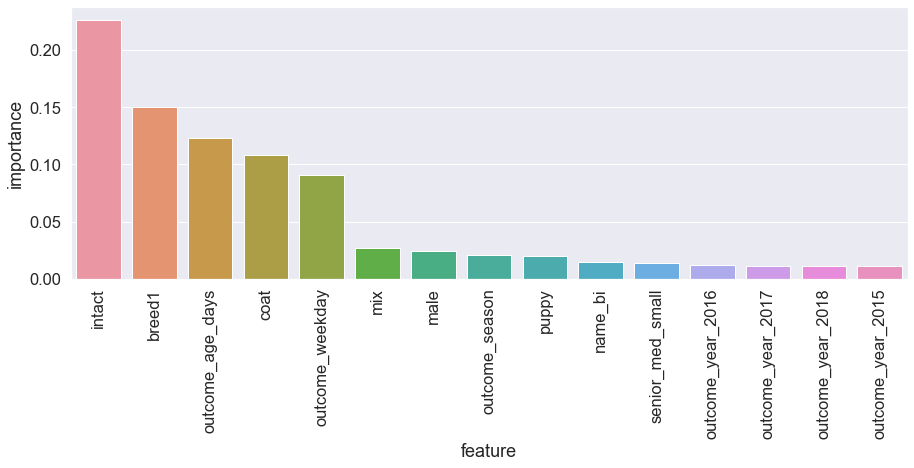

In [110]:
feature_importances = rfc3.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': Xd.columns}, 
                           index=Xd.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])